# Timescales for Salinity Reintroduction after Hurricane Harvey

## Set up for analysis and read in data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.dates
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import shapely

In [4]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

b = '../data/'
baseb = b + 'bathy/'
basesf = b + 'shapefiles/'
based = b + 'stations/'

# Bathymetry was processed previously. See https://github.com/kthyng/harvey_inflow/blob/master/notebooks/Process%20bathymetry.ipynb
d = np.load(baseb + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(baseb + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)

In [5]:
run buoy_info.py

In [8]:
# See make_data notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(based + 'data08to08-15min.csv', parse_dates=True, index_col=0)

dstart = '2017-08-01'; dend = '2018-08-01'

# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())

# remove bad data
df['8770613: Salinity']['2017-9-20 09:00'] = np.nan  # bad data point
df['8770613: Salinity']['2017-9-20 9:00':'2017-9-20 11:00'] = np.nan
df['B: Salinity'][df['B: Salinity'] < 18] = np.nan
df['B: Salinity'][df['B: Salinity'] > 50] = np.nan


In [7]:
# set up salinity column names
saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]

## Data used in study

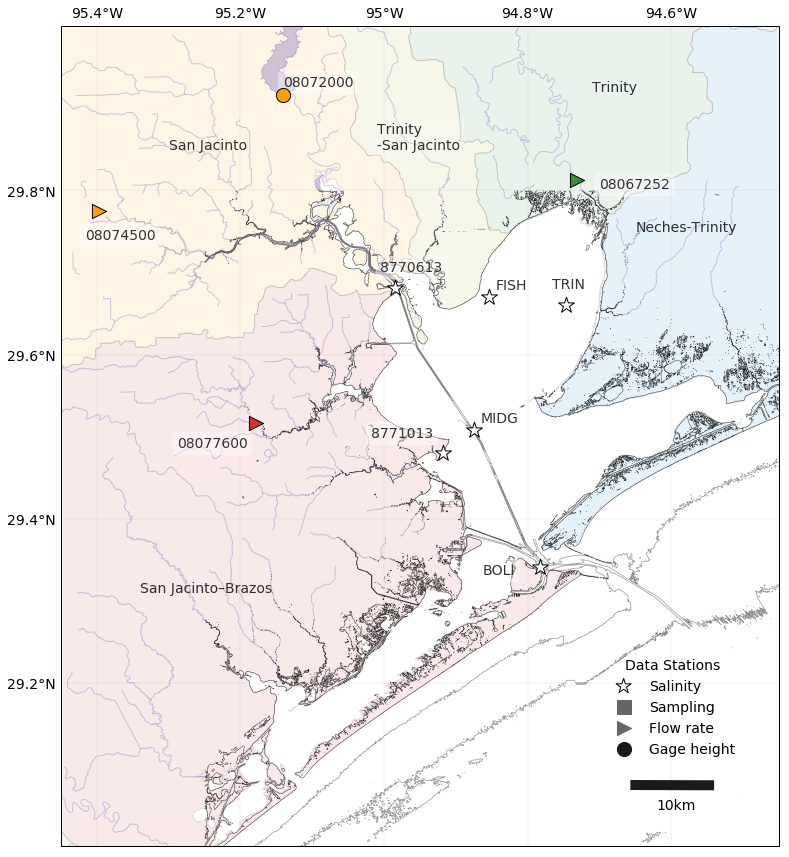

In [12]:

extent = [-95.45, -94.45, 29, 30.0]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
# mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
# cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
# cb.set_label('Depth [m]')

# # add background land
# ax.add_feature(land_10m)

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# bathymetry contours to highlight shipping lanes
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-', alpha=0.4)  # some values


# Add river basins to plot
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
## add buoys ##
for buoy in ['08067252','08074500','08077600','08072000','TRIN', 'FISH', 'MIDG', '8771013', '8770613', 'BOLI', ]:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == '08074500':
        lonsh += 0.08
    elif buoy == '08077600':
        lonsh += 0.05
    elif buoy == '8771013':
        lonsh += 0.05
    elif buoy == 'BOLI':
        latsh -= 0.03
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.2', bbox=props)
    for var in ['Gage height [m]','Salinity','Rain [cm]', 'Flow rate [m^3/s]']:
        if var in buoys[buoy]['vars']:
            kwargs = plots[var]
            # use buoy color in some cases
            if not 'color' in kwargs:
                color = buoys[buoy]['color']
                ax.scatter(*buoys[buoy]['ll'], **kwargs, facecolors=color, transform=pc, label=var, edgecolors='k', zorder=5)
            else:
                ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)                
                
# Add labels
ax.text(-95.3, 29.85, 'San Jacinto', transform=pc, alpha=0.8)
ax.text(-95.01, 29.85, 'Trinity\n-San Jacinto', transform=pc, alpha=0.8, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.34, 29.31, 'San Jacinto–Brazos', transform=pc, alpha=0.8)
ax.text(-94.71, 29.92, 'Trinity', transform=pc, alpha=0.8)
ax.text(-94.65, 29.75, 'Neches-Trinity', transform=pc, alpha=0.8);

# Distance key
llon, llat = -94.65, 29.075
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.03, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.72, 0.1, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.4', s=200, marker='s', label='Sampling')
# ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Gage height')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('../figures/map.png', bbox_inches='tight', dpi=300)
fig.savefig('../figures/map_lowres.png', bbox_inches='tight')


## Salinity timescales

### Recovery based on absolute salinity values

In [13]:
times = {'TRIN': {'fresh': '2017-8-30 00:00', 'start': '2017-9-17 12:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['TRIN: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},
         'FISH': {'fresh': '2017-8-30 00:00', 'start': '2017-9-11 8:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['FISH: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},                  
         '8770613': {'fresh': '2017-8-29 00:00', 'start': '2017-9-5 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [np.round(1.58496)], 'dx': -0.04},
         'MIDG': {'fresh': '2017-8-29 00:00', 'start': '2017-9-2 00:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['MIDG: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())], 'dx': -0.04},                  
         '8771013': {'fresh': '2017-8-29 12:00', 'start': '2017-9-12 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [1.28016], 'dx': 0},
         'BOLI': {'fresh': '2017-8-30 00:00', 'start': '2017-9-1 00:00', 'stop': '2017-10-11 00:00', 
                  'depths': [np.round(df['BOLI: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                  'dx': -0.04},
}

In [14]:
date_outflow = pd.Timestamp('2017-8-26 14:30')  # when salinity starts to drop, based on velocity
date_fresh = pd.Timestamp('2017-8-31 00:00')  # all stations approximately fresh
date_ssh = pd.Timestamp('2017-8-24 16:00')  # when sea surface starts to raise

# calculate lag times, which only depend on start time I chose vs. outflow start time
# Start time scale dictionary, tau
tau = dict()

for key in times.keys():
    tau[key] = dict()
    tau[key]['lag'] = (pd.Timestamp(times[key]['start']) - date_fresh).total_seconds()/86400

TRIN 7.873432956084003 16.552083333333332 46.60416666666667 2017-10-16 14:30:00
FISH 10.274163592993398 23.020833333333332 46.21875 2017-10-16 05:15:00
8770613 12.505173010380624 28.520833333333332 43.59375 2017-10-13 14:15:00
MIDG 22.745673704087096 41.354166666666664 67.29166666666667 2017-11-06 07:00:00
8771013 14.627750865051915 24.5 57.71875 2017-10-27 17:15:00
BOLI 27.030485551440165 14.145833333333334 59.822916666666664 2017-10-29 19:45:00


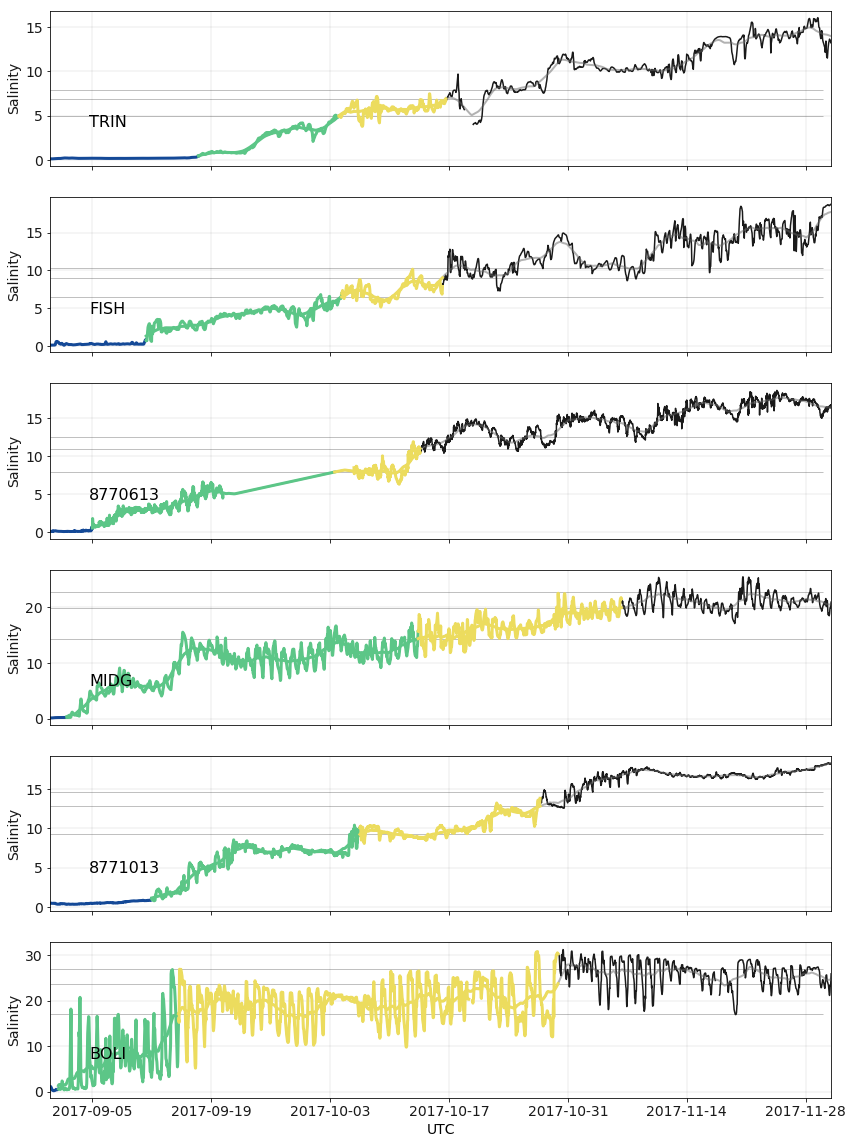

In [15]:
# cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', 'H1', 'H2', 'H3', 'H4', 'MIDG: Salinity']
cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', 'MIDG: Salinity', '8771013: Salinity', 'BOLI: Salinity']

colorlag = '#144997' 
colorefold = '#5CC687'
color12 = '#ECDC5E'

dst = date_fresh; den = '2017-11-30'  # '2017-10-15'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,20), sharex=True)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # get fit in linear space
    name = col.split(':')[0]

    start = times[name]['start']
#     stop = times[name]['stop']

    tnums = df['idx'][start:den] - df['idx'][start]  # decimal days
    dfshort = df[col].interpolate().rolling(center=True, window=288).mean()[start:den]
#     dfshort = df[col][start:den]
    
    S0 = df[col][date_ssh-pd.Timedelta('3 days'):date_ssh].mean()  # "initial" salinity before freshwater inflow
    time37 = dfshort.index[np.where((1-dfshort/S0)<=(1/np.e))[0][0]]  # time at 37%*S0 salinity, datetime when efolding time happens
    tau[name]['efold'] = (time37 - pd.Timestamp(start)).total_seconds()/86400  # save e folding tau, in units of days

    time12 = dfshort.index[np.where((1-dfshort/S0)<=(1/(3*np.e)))[0][0]]
    tau[name]['timeto12'] = tau[name]['lag'] + (time12 - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days
    print(name, S0, tau[name]['efold'], tau[name]['timeto12'], time12)

    # plot
    color = '0.1'
    ax.plot(df[dst:den].index, df[col][dst:den], color=color)  # plot data
    ax.plot(dfshort, color='0.4', lw=2, alpha=0.5)  # plot data
    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)
    # overlay lag time
    tstrlag = date_fresh + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(df[date_fresh:tstrlag].index, df[col][date_fresh:tstrlag], color=colorlag, lw=3)  # plot data
    # overlay efolding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(df[start:tstrefold].index, df[col][start:tstrefold], color=colorefold, lw=3)  # plot data
    ax.plot(dfshort[:tstrefold].index, dfshort[:tstrefold], color=colorefold, lw=3)  # plot data
    # overlay time to 12%
    tstr12 = date_fresh + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
    ax.plot(df[tstrefold:tstr12].index, df[col][tstrefold:tstr12], color=color12, lw=3)  # plot data
    ax.plot(dfshort[tstrefold:tstr12].index, dfshort[tstrefold:tstr12], color=color12, lw=3)  # plot data
    
#     tstr12 = date_outflow + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
#     ax.fill_between(df[date_outflow:tstr12].index, 0, df[col][date_outflow:tstr12], color='k', alpha=0.1)
    
    # write station name and tau
    ax.text(0.05, 0.25, name, transform=ax.transAxes, fontsize=16)
    
#     hours = mpl.dates.HourLocator(byhour=np.arange(0,24,12))
#     ax.xaxis.set_minor_locator(hours)
#     days = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
#     ax.xaxis.set_major_locator(days)

#     ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
#     # label outflow start
    ylims = ax.get_ylim()
#     ax.set_ylim(0, ylims[1])
#     if j == 0:  # first subplot, leaving space for line labels
#         ax.set_ylim(0, 15)
#         ylims = 0, 15
#         # label lines
#         ax.text(0.3, 0.82, 'lag time', transform=ax.transAxes, color=colorlag)
#         ax.text(0.5, 0.82, 'e-folding time', transform=ax.transAxes, color=colorefold)
#         ax.text(0.4, 0.07, 'time to 12% salinity', transform=ax.transAxes, color='k', alpha=0.3)
#     ax.vlines(date_fresh, *ylims, linewidth=4, alpha=0.2, color='k')
    ax.hlines(S0, df.loc[dst,:].idx, df.loc[den,:].idx, color='0.3', linewidth=0.7, alpha=0.5)
    ax.hlines(S0*(1-(1/(3*np.e))), df.loc[dst,:].idx, df.loc[den,:].idx, color='0.3', linewidth=0.7, alpha=0.5)
    ax.hlines(S0*(1-(1/np.e)), df.loc[dst,:].idx, df.loc[den,:].idx, color='0.3', linewidth=0.7, alpha=0.5)

# axes[0].set_title('Salinity time scales')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


# fig.savefig('figures/times_flushing.pdf', bbox_inches='tight')

### Recovery, normalized by relationship with shelf salinity

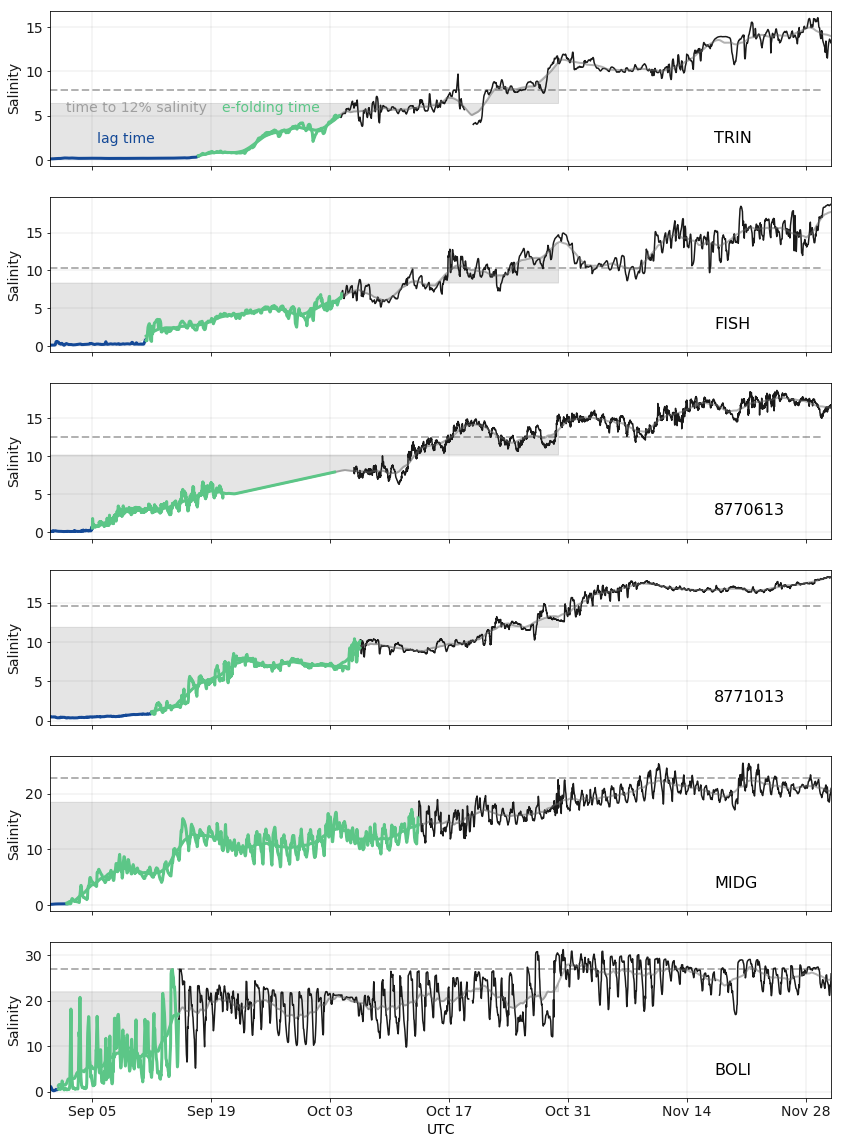

In [16]:
# cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', 'H1', 'H2', 'H3', 'H4', 'MIDG: Salinity']
cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', '8771013: Salinity', 'MIDG: Salinity', 'BOLI: Salinity']

colorlag = '#144997' 
colorefold = '#5CC687'
color12 = '#ECDC5E'

dst = date_fresh; den = '2017-11-30'  # '2017-10-15'
fig, axes = plt.subplots(len(saltcols), 1, figsize=(14,20), sharex=True)

taus = np.empty(len(saltcols))
for j, (col, ax) in enumerate(zip(cols, axes)):

    # get fit in linear space
    name = col.split(':')[0]

    start = times[name]['start']
#     stop = times[name]['stop']

    tnums = df['idx'][start:den] - df['idx'][start]  # decimal days
    dfmean = df[col].interpolate().rolling(center=True, window=288).mean()
    dfshort = dfmean[start:den]
    
    S0 = df[col][date_ssh-pd.Timedelta('3 days'):date_ssh].mean()  # "initial" salinity before freshwater inflow
    time37 = dfshort.index[np.where((1-dfshort/S0)<=(1/np.e))[0][0]]  # time at 37%*S0 salinity, datetime when efolding time happens
    tau[name]['efold'] = (time37 - pd.Timestamp(start)).total_seconds()/86400  # save e folding tau, in units of days

    time12 = dfshort.index[np.where((1-dfshort/S0)<=(1/(2*np.e)))[0][0]]
    tau[name]['timeto12'] = tau[name]['lag'] + (time12 - pd.Timestamp(start)).total_seconds()/86400  # save lag + flooding time to 12% S0, in days
#     print(name, S0, tau[name]['efold'], tau[name]['timeto12'], time12)

    # plot
    color = '0.1'
    ax.plot(df[dst:den].index, df[col][dst:den], color=color)  # plot data
    ax.plot(dfshort, color='0.4', lw=2, alpha=0.5)  # plot data
    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)
    # overlay lag time
    tstrlag = date_fresh + pd.Timedelta(str(tau[name]['lag']) + 'days')
    ax.plot(df[date_fresh:tstrlag].index, df[col][date_fresh:tstrlag], color=colorlag, lw=3)  # plot data
    # overlay efolding time
    tstrefold = pd.Timestamp(start) + pd.Timedelta(str(tau[name]['efold']) + 'days')
    ax.plot(df[start:tstrefold].index, df[col][start:tstrefold], color=colorefold, lw=3)  # plot data
    ax.plot(dfshort[:tstrefold].index, dfshort[:tstrefold], color=colorefold, lw=3)  # plot data
#     # overlay time to 12%
#     tstr12 = date_fresh + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
#     ax.plot(df[tstrefold:tstr12].index, df[col][tstrefold:tstr12], color=color12, lw=3)  # plot data
#     ax.plot(dfshort[tstrefold:tstr12].index, dfshort[tstrefold:tstr12], color=color12, lw=3)  # plot data
    
#     tstr12 = date_outflow + pd.Timedelta(str(tau[name]['timeto12']) + 'days')
    ax.fill_between(dfmean[date_fresh:tstr12].index, dfmean[date_fresh:tstr12], S0*(1-(1/(2*np.e))), color='k', alpha=0.1)
    
    # write station name and tau
    ax.text(0.85, 0.15, name, transform=ax.transAxes, fontsize=16)
    
#     hours = mpl.dates.HourLocator(byhour=np.arange(0,24,12))
#     ax.xaxis.set_minor_locator(hours)
#     days = mpl.dates.HourLocator(byhour=np.arange(0,24,24))
#     ax.xaxis.set_major_locator(days)

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)
    
#     # label outflow start
    ylims = ax.get_ylim()
#     ax.set_ylim(0, ylims[1])
    if j == 0:  # first subplot, leaving space for line labels
#         ax.set_ylim(0, 15)
#         ylims = 0, 15
        # label lines
        ax.text(0.06, 0.15, 'lag time', transform=ax.transAxes, color=colorlag)
        ax.text(0.22, 0.35, 'e-folding time', transform=ax.transAxes, color=colorefold)
        ax.text(0.02, 0.35, 'time to 12% salinity', transform=ax.transAxes, color='k', alpha=0.3)
#     ax.vlines(date_fresh, *ylims, linewidth=4, alpha=0.2, color='k')
    ax.hlines(S0, df.loc[dst,:].idx, df.loc[den,:].idx, color='k', linewidth=2, alpha=0.3, linestyle='--')
#     ax.hlines(S0*(1-(1/(3*np.e))), df.loc[dst,:].idx, df.loc[den,:].idx, color='r', linewidth=2, alpha=0.3, linestyle=':')
#     ax.hlines(S0*(1-(1/np.e)), df.loc[dst,:].idx, df.loc[den,:].idx, color='r', linewidth=2, alpha=0.3, linestyle=':')

# axes[0].set_title('Salinity time scales')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)


# fig.savefig('figures/times_recovery.pdf', bbox_inches='tight')